# Lab 6B: Solving Macro Models with Neural Networks
## From Euler Equations to Deep Value Function Iteration

---

### 🎯 Lab Philosophy

In Lab 6A, we solved the model using a grid and iterating on the Value Function ($V$). 

In this lab, we explore **two powerful Deep Learning approaches** to solve high-dimensional macro models without grids:

1.  **Euler Equation Minimization (Part 1)**: Training a network to satisfy the First Order Conditions (FOCs). This is the standard "Economics" approach.
2.  **Deep Value Function Iteration (Part 2)**: Training a network to directly maximize the discounted sum of utilities. This is the "Reinforcement Learning" approach.

### 📚 Coverage

**Part 1: Euler Equation Minimization**
-   **Objective**: Minimize the residual of the Euler Equation.
-   **Pros**: Very precise policy functions; theoretically grounded.
-   **Cons**: Does not yield the Value Function ($V$); requires deriving FOCs.

**Part 2: Deep Value Function Iteration (DVFI)**
-   **Objective**: Maximize lifetime utility $\sum \beta^t u(c_t)$ directly.
-   **Innovation**: Uses **T-step lookahead** and **Soft Constraints** to handle boundaries.
-   **Pros**: Provides both Policy and Value functions; handles inequality constraints naturally via penalties.

---

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime

# Common Device Setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


/Users/zfeng/Library/CloudStorage/OneDrive-Personal/Teaching_Notes/AI_ML/Lecture_notes_2026/Notebooks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1: Euler Equation Minimization

We define a neural network that takes current capital $k_t$ and outputs next period capital $k_{t+1}$.

**The Logic:**
We minimize the Euler Error: $EE = \frac{u'(c_t)}{\beta E [u'(c_{t+1}) f'(k_{t+1})]} - 1$.

In [2]:
# 1. Load Parameters for Part 1
params_euler = {
    "alpha": 0.33,
    "beta": 1.0,
    "delta": 0.72,
    "c_eps": 1e-5,
    "k_min": 0.1001,
    "k_max": 2.5,
    "n_episode": 5000,
    "n_epoch": 2000, # Reduced for demo speed
    "lr": 0.0001,
    "n1": 20,
    "n2": 50,
    "device": device
}

class PolicyNetwork(nn.Module):
    """Neural network with constrained output range"""

    def __init__(self, alpha, c_eps, n1=20, n2=50):
        super().__init__()
        self.alpha = alpha
        self.c_eps = c_eps
        self.net = nn.Sequential(
            nn.Linear(1, n1),
            nn.ReLU(),
            nn.Linear(n1, n2),
            nn.ReLU(),
            nn.Linear(n2, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, k0):
        # Scale sigmoid output to [0, k0^alpha - c_eps]
        # This ensures we never consume negative amounts
        raw_output = self.net(k0)
        max_capital = torch.clamp(k0 ** self.alpha - self.c_eps, min=1e-9)
        return raw_output * max_capital

class EulerSolver:
    def __init__(self, params):
        # Load parameters
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.c_eps = params['c_eps']
        self.k_min = params['k_min']
        self.k_max = params['k_max']
        self.n_episode = params['n_episode']
        self.n_epoch = params['n_epoch']
        self.lr = params['lr']
        self.device = params['device']

        # Initialize constrained network
        self.decision_rule = PolicyNetwork(
            alpha=self.alpha,
            c_eps=self.c_eps,
            n1=params['n1'],
            n2=params['n2']
        ).to(self.device)

        # Optimization setup
        self.optimizer = torch.optim.Adam(self.decision_rule.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()
        self.losses = []

        # Capital grid for evaluation plots
        self.k_vec = torch.linspace(self.k_min, self.k_max, self.n_episode,
                                    device=self.device).view(-1, 1)

    def simulate(self, k0):
        """Simulate capital path for two periods to calculate Euler error"""
        k0 = k0.to(self.device)

        # 1. Current period decision
        k1 = self.decision_rule(k0)
        c0 = torch.clamp(k0 ** self.alpha - k1, min=self.c_eps)

        # 2. Next period decision (to get c1)
        k2 = self.decision_rule(k1)
        c1 = torch.clamp(k1 ** self.alpha - k2, min=self.c_eps)

        # 3. Calculate marginal product (r1)
        r1 = self.alpha * torch.clamp(k1, min=1e-6) ** (self.alpha - 1)

        # 4. Euler equation residual
        # Based on provided code structure: c1 / (c0 * r1 * beta * delta) - 1
        denominator = c0 * r1 * self.beta * self.delta + 1e-9
        ee_errors = (c1 / denominator) - 1

        return k1, ee_errors

    def train(self):
        """Training loop"""
        print(f"[Euler Method] Training started on {self.device}")
        pbar = tqdm(total=self.n_epoch, desc="Euler Training", unit="epoch")

        for epoch in range(self.n_epoch):
            self.optimizer.zero_grad()

            # Generate random initial capital states
            k0 = torch.clamp(
                (self.k_max - self.k_min) * torch.rand(self.n_episode, 1, device=self.device) + self.k_min,
                min=1e-6
            )

            # Forward pass
            _, ee_errors = self.simulate(k0)

            # Calculate loss (Mean Squared Euler Error)
            loss = self.loss_fn(ee_errors, torch.zeros_like(ee_errors))
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(self.decision_rule.parameters(), 1.0)
            self.optimizer.step()

            self.losses.append(loss.item())
            pbar.set_postfix({'Loss': f"{loss.item():.4e}"})
            pbar.update(1)

        pbar.close()

    def plot_results(self):
        """Visualize results"""
        with torch.no_grad():
            k_pred = self.decision_rule(self.k_vec).cpu().numpy()
            k_analytical = self.alpha * self.delta * self.k_vec.cpu().numpy() ** self.alpha

            plt.figure(figsize=(10, 6))
            plt.plot(self.k_vec.cpu(), k_pred, 'b-', label='Euler NN Policy')
            plt.plot(self.k_vec.cpu(), k_analytical, 'r--', label='Analytical Policy')
            plt.title("Part 1: Euler Method Results")
            plt.xlabel('Capital')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

[Euler Method] Training started on cpu


Euler Training: 100%|██████████| 2000/2000 [00:08<00:00, 231.71epoch/s, Loss=8.4026e-05]


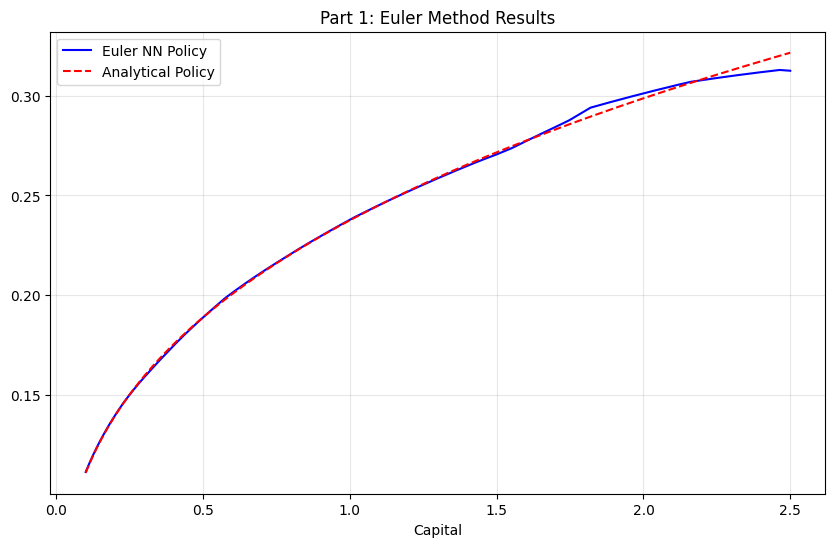

In [3]:
# Run Part 1
euler_solver = EulerSolver(params_euler)
euler_solver.train()
euler_solver.plot_results()

# Part 2: Deep Value Function Iteration (DVFI)

Now we introduce the advanced method: **Unified Objective Maximization**.

## Discussion of Methods

### Why do we need this?
While the Euler method (Part 1) is fast and accurate for the policy, it has limitations:
1.  **No Value Function**: It tells you *what to do*, but not *how good it is* ($V(k)$). Welfare analysis is impossible.
2.  **Gradient Instability**: Minimizing the Euler residual involves second derivatives (or complex products) which can be unstable in complex models.
3.  **Inequality Constraints**: Handling $c > 0$ or $k > 0$ strictly can be difficult with Euler equations (Kuhn-Tucker conditions).

### The DVFI Approach
Instead of differentiating the math first, we simply ask the neural network to **Maximize the Reward** directly.

#### Key Innovations in this Code:

1.  **Unified Objective ($J$)**: We define the objective as the T-step discounted sum of utilities plus a terminal value estimate:
    $$ J(y_0) = \sum_{t=0}^{T-1} \beta^t u(c_t) + \beta^T V(y_T) $$
    
2.  **T-Step Lookahead**: To reduce bias, we don't just look one step ahead. We simulate the economy for $T=30$ or $50$ periods. This allows the gradients to "see" the long-term consequences of a policy choice.

3.  **Soft Constraints (The Penalty)**: Instead of hard-clamping consumption (which kills gradients), we use a "Soft Barrier":
    * If $c > 0$: $u = \ln(c)$
    * If $c \le 0$: $u = \text{Penalty} \times (c - \epsilon)$
    This pushes the policy back into the feasible region naturally.

4.  **Separated Training Loops**:
    * **Policy Net**: Updates to Maximize $J$.
    * **Value Net**: Updates to Minimize the error $|| V(y_0) - J ||$. (Standard Regression).

### The Model Setup (Standard Benchmark)
For this section, we use the standard **Stochastic Optimal Growth** parameters to validate against a known closed-form solution:
-   $\delta = 1.0$ (Full depreciation)
-   $\alpha = 0.65$
-   $\beta = 0.9$

In [4]:
# -----------------------------------------------------------
# 1. Generic Neural Network Block
# -----------------------------------------------------------
class MLP(nn.Module):
    """
    A simple Multi-Layer Perceptron.
    - 'output_activation': Optional activation for the final layer.
    """
    def __init__(self, input_dim=1, hidden_dim=128, output_dim=1, output_activation=None):
        super().__init__()
        layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        ]
        if output_activation:
            layers.append(output_activation)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# -----------------------------------------------------------
# 2. The Deep Value Solver Class
# -----------------------------------------------------------
class DeepValueSolver:
    def __init__(self, config):
        """
        Initializes the solver with economic parameters and training settings.
        """
        self.alpha = config.get("alpha", 0.34)
        self.beta  = config.get("beta", 0.9)
        self.device = config.get("device", torch.device("cpu"))
        
        # Training Hyperparameters
        self.batch_size = config.get("batch_size", 128)
        self.T_sim      = config.get("T_sim", 50)
        self.lr         = config.get("lr", 1e-3)
        
        # Soft Constraint Parameters
        self.c_epsilon = 1e-4
        self.penalty_factor = 1000.0
        
        # Stochastic Shocks (Log-Normal)
        self.shock_mean = 0.0
        self.shock_std  = 0.1
        
        # Initialize State Space Bounds
        self._init_bounds()
        
        # Initialize Networks
        # Value Net: Approximates V(y) -> scalar
        self.value_net = MLP(output_activation=None).to(self.device)
        
        # Policy Net: Approximates k'(y) -> scalar
        # We use Softplus to ensure the raw network output is strictly positive
        self.policy_net = MLP(output_activation=nn.Softplus()).to(self.device)
        
        # Optimizers
        self.opt_val = torch.optim.Adam(self.value_net.parameters(), lr=self.lr)
        self.opt_pol = torch.optim.Adam(self.policy_net.parameters(), lr=self.lr)

    def _init_bounds(self):
        """
        Calculates steady state capital and sets the upper bound for sampling.
        k_ss = (alpha * beta)^(1 / (1 - alpha))
        """
        # Analytical Steady State for k
        self.k_ss = (self.alpha * self.beta) ** (1 / (1 - self.alpha))
        
        # Analytical Steady State for y (Output)
        # Assuming mean shock E[z] approx 1 for bounds calculation
        self.y_ss = self.k_ss ** self.alpha
        
        # Upper bound as requested: 1.5 * k_ss
        k_max = 1.5 * self.k_ss
        
        # Convert k_max to corresponding y_max (wealth)
        # This ensures our state space covers the relevant range
        self.y_max = k_max ** self.alpha
        self.y_min = 0.01
        
        print(f"--- DVFI Model Initialized ---")
        print(f"Steady State k*: {self.k_ss:.4f}")
        print(f"Steady State y*: {self.y_ss:.4f}")
        print(f"Training Bounds (y): [{self.y_min}, {self.y_max:.4f}]")

    def get_shocks(self, shape):
        """Generates log-normal productivity shocks."""
        eps = torch.randn(shape, device=self.device)
        return torch.exp(self.shock_mean + self.shock_std * eps)

    def penalized_utility(self, c_raw):
        """
        Computes log(c) with a soft penalty if c <= 0.
        Logic:
          1. If c <= 0, push it to epsilon for log calc.
          2. Add linear penalty proportional to violation distance.
        """
        # Safe consumption for log calculation
        c_safe = torch.clamp(c_raw, min=self.c_epsilon)
        u = torch.log(c_safe)
        
        # Penalty term
        # violation is positive if c_raw < c_epsilon
        violation = torch.relu(self.c_epsilon - c_raw)
        penalty = self.penalty_factor * violation
        
        return u - penalty

    def simulate_trajectory(self, y_initial):
        """
        Simulates the economy for T_sim periods.
        Returns the discounted sum of utilities (The 'Objective').
        """
        y_curr = y_initial
        cumulative_utility = 0.0
        discount = 1.0
        
        for _ in range(self.T_sim):
            # 1. Policy Choice: k' = g(y)
            k_prime = self.policy_net(y_curr)
            
            # 2. Implied Consumption: c = y - k'
            c_raw = y_curr - k_prime
            
            # 3. Utility with Penalty
            u = self.penalized_utility(c_raw)
            cumulative_utility += discount * u
            
            # 4. Transition: y' = z * (k')^alpha
            z = self.get_shocks(y_curr.shape)
            y_next = z * (k_prime ** self.alpha)
            
            # Update
            y_curr = y_next
            discount *= self.beta
            
        # 5. Bootstrap Terminal Value
        # Add the continuation value V(y_T) estimated by ValueNet
        v_terminal = self.value_net(y_curr)
        total_objective = cumulative_utility + discount * v_terminal
        
        return total_objective

    def train_step(self):
        # 1. Sample state batch (Wealth y)
        # Uniform sampling within the steady-state defined bounds
        y0 = torch.rand(self.batch_size, 1, device=self.device)
        y0 = y0 * (self.y_max - self.y_min) + self.y_min
        
        # 2. Compute Simulation Objective (J)
        # This graph tracks gradients back to Policy parameters
        J_objective = self.simulate_trajectory(y0)
        
        # ----------------------------------------
        # Phase A: Train Policy
        # Objective: Maximize J (or Minimize -J)
        # ----------------------------------------
        self.opt_pol.zero_grad()
        loss_pol = -torch.mean(J_objective)
        
        # Retain graph because we need J_objective for Phase B (optionally)
        # or simply because we generated J using PolicyNet
        loss_pol.backward(retain_graph=True)
        self.opt_pol.step()
        
        # ----------------------------------------
        # Phase B: Train Value Function
        # Objective: V(y0) should estimate J(y0)
        # Critical: Detach J so we don't train Policy via Value loss
        # ----------------------------------------
        target_val = J_objective.detach()
        
        self.opt_val.zero_grad()
        pred_val = self.value_net(y0)
        loss_val = nn.functional.mse_loss(pred_val, target_val)
        loss_val.backward()
        self.opt_val.step()
        
        return loss_pol.item(), loss_val.item()

    def train(self, epochs=5000):
        print(f"[DVFI Method] Starting training for {epochs} epochs...")
        pbar = tqdm(range(epochs))
        history = {'reward': [], 'v_loss': []}
        
        for _ in pbar:
            l_pol, l_val = self.train_step()
            history['reward'].append(-l_pol)
            history['v_loss'].append(l_val)
            
            if _ % 100 == 0:
                pbar.set_postfix({'Reward': -l_pol, 'V_MSE': l_val})
                
        return history

    def validate_against_closed_form(self):
        """
        Checks results against the Delta=1.0 (Full Depreciation) closed form solution.
        k* = alpha * beta * y
        """
        # Generate evaluation grid
        y_grid = torch.linspace(self.y_min, self.y_max, 200, device=self.device).unsqueeze(1)
        
        with torch.no_grad():
            k_pred = self.policy_net(y_grid)
            v_pred = self.value_net(y_grid)
            
        # Convert to numpy
        y = y_grid.cpu().numpy()
        k = k_pred.cpu().numpy()
        v = v_pred.cpu().numpy()
        
        # Closed Form (Specific to Log Utility + Full Depreciation)
        k_true = self.alpha * self.beta * y
        
        # Plotting
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        
        # 1. Policy Function
        ax[0].plot(y, k, 'b-', lw=3, label='DVFI Policy')
        ax[0].plot(y, k_true, 'r--', lw=2, label=f'Closed Form ($\\alpha\\beta y$)')
        ax[0].set_title("Part 2: Policy Function Validation")
        ax[0].set_xlabel("Wealth (y)")
        ax[0].set_ylabel("Investment (k')")
        ax[0].legend()
        ax[0].grid(True, alpha=0.3)
        
        # 2. Savings Rate (Should be constant)
        s_rate_pred = k / y
        s_rate_true = self.alpha * self.beta
        
        ax[1].plot(y, s_rate_pred, 'g-', lw=2, label='DVFI Savings Rate')
        ax[1].axhline(s_rate_true, color='r', linestyle='--', label=f'True Rate ({s_rate_true:.2f})')
        ax[1].set_ylim(0, 1.0)
        ax[1].set_title("Savings Rate Check ($k'/y$)")
        ax[1].set_xlabel("Wealth (y)")
        ax[1].legend()
        ax[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

--- DVFI Model Initialized ---
Steady State k*: 0.2161
Steady State y*: 0.3695
Training Bounds (y): [0.01, 0.4809]
[DVFI Method] Starting training for 3000 epochs...


100%|██████████| 3000/3000 [00:31<00:00, 95.85it/s, Reward=-20.3, V_MSE=0.279]


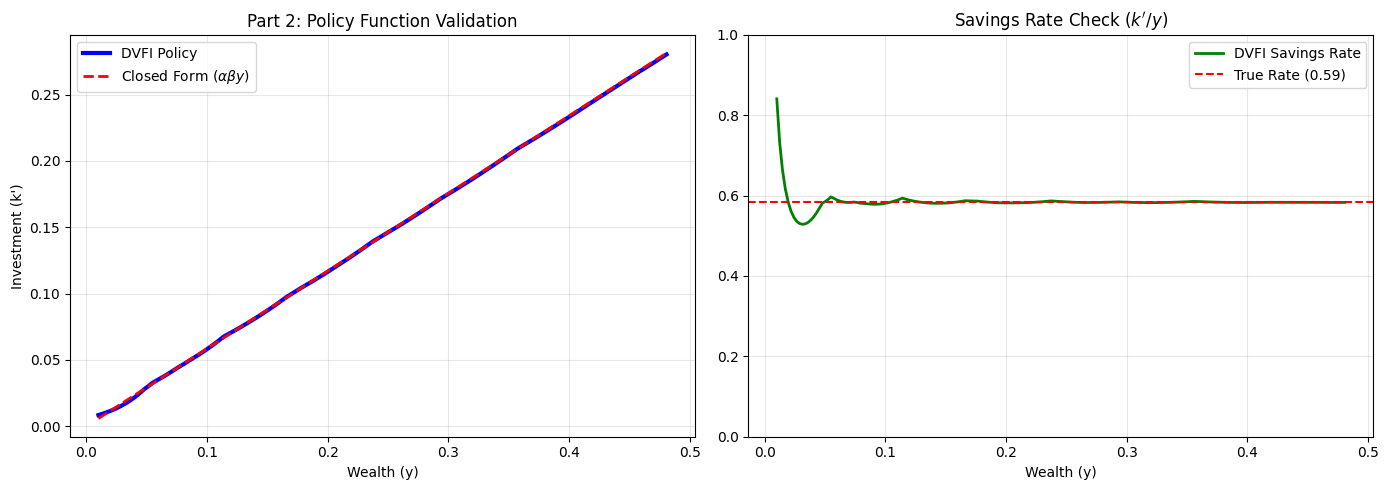

In [5]:
# Configuration for Part 2
config_dvfi = {
    "alpha": 0.65,
    "beta": 0.9,       # Requirement: beta = 0.9
    "batch_size": 128,
    "T_sim": 30,       # Requirement: T-period simulation
    "lr": 1e-3,
    "device": device
}

# Instantiate
dvfi_solver = DeepValueSolver(config_dvfi)

# Train
history = dvfi_solver.train(epochs=3000)

# Validate
dvfi_solver.validate_against_closed_form()